# Deep Q-Learning 

Install dependencies for AI gym to run properly (shouldn't take more than a minute). If running on google cloud or running locally, only need to run once. Colab may require installing everytime the vm shuts down.

In [ ]:
!pip3 install gym pyvirtualdisplay
!sudo apt-get install -y xvfb python-opengl ffmpeg

In [ ]:
!pip3 install --upgrade setuptools --user
!pip3 install ez_setup 
!pip3 install gym[atari] 
!pip3 install gym[accept-rom-license] 

For this assignment we will implement the Deep Q-Learning algorithm with Experience Replay as described in breakthrough paper __"Playing Atari with Deep Reinforcement Learning"__. We will train an agent to play the famous game of __Breakout__.

In [1]:
%matplotlib inline

import sys
import gym
import torch
import pylab
import random
import numpy as np
from collections import deque
from datetime import datetime
from copy import deepcopy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from utils import find_max_lives, check_live, get_frame, get_init_state
from model import DQN
from config import *

import matplotlib.pyplot as plt
# %load_ext autoreload
# %autoreload 2

## Understanding the environment

In the following cell, we initialize our game of __Breakout__ and you can see how the environment looks like. For further documentation of the of the environment refer to https://www.gymlibrary.dev/environments/atari/breakout/. 

In breakout, we will use 3 actions "fire", "left", and "right". "fire" is only used to reset the game when a life is lost, "left" moves the agent left and "right" moves the agent right.

In [2]:
env = gym.make('BreakoutDeterministic-v4')
state = env.reset()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [3]:
number_lives = find_max_lives(env)
state_size = env.observation_space.shape
action_size = 3 #fire, left, and right

## Creating a DQN Agent

Here we create a DQN Agent. This agent is defined in the __agent.py__. The corresponding neural network is defined in the __model.py__. Once you've created a working DQN agent, use the code in agent.py to create a double DQN agent in __agent_double.py__. Set the flag "double_dqn" to True to train the double DQN agent.

__Evaluation Reward__ : The average reward received in the past 100 episodes/games.

__Frame__ : Number of frames processed in total.

__Memory Size__ : The current size of the replay memory.

In [4]:
double_dqn = False # set to True if using double DQN agent

if double_dqn:
    from agent_double import Agent
else:
    from agent import Agent

agent = Agent(action_size)
evaluation_reward = deque(maxlen=evaluation_reward_length)
frame = 0
memory_size = 0

### Main Training Loop

In this training loop, we do not render the screen because it slows down training signficantly. To watch the agent play the game, run the code in next section "Visualize Agent Performance"

# DQN

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


episode: 0   score: 1.0   memory length: 7670   epsilon: 1.0    steps: 151    lr: 0.0001     evaluation reward: 1.4878048780487805
episode: 1   score: 0.0   memory length: 7793   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 1.4523809523809523
episode: 2   score: 3.0   memory length: 8060   epsilon: 1.0    steps: 267    lr: 0.0001     evaluation reward: 1.4883720930232558
episode: 3   score: 2.0   memory length: 8279   epsilon: 1.0    steps: 219    lr: 0.0001     evaluation reward: 1.5
episode: 4   score: 0.0   memory length: 8401   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.4666666666666666
episode: 5   score: 3.0   memory length: 8626   epsilon: 1.0    steps: 225    lr: 0.0001     evaluation reward: 1.5
episode: 6   score: 0.0   memory length: 8748   epsilon: 1.0    steps: 122    lr: 0.0001     evaluation reward: 1.4680851063829787
episode: 7   score: 3.0   memory length: 8996   epsilon: 1.0    steps: 248    lr: 0.0001     evaluation reward: 1

/home/vanshporwal/memory.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.array(sample)
/home/vanshporwal/agent.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(mini_batch).transpose()


episode: 506   score: 3.0   memory length: 100173   epsilon: 0.9996535000000075    steps: 244    lr: 0.0001     evaluation reward: 1.33
episode: 507   score: 0.0   memory length: 100296   epsilon: 0.9994099600000128    steps: 123    lr: 0.0001     evaluation reward: 1.31
episode: 508   score: 1.0   memory length: 100466   epsilon: 0.9990733600000201    steps: 170    lr: 0.0001     evaluation reward: 1.3
episode: 509   score: 2.0   memory length: 100665   epsilon: 0.9986793400000287    steps: 199    lr: 0.0001     evaluation reward: 1.28
episode: 510   score: 2.0   memory length: 100863   epsilon: 0.9982873000000372    steps: 198    lr: 0.0001     evaluation reward: 1.28
episode: 511   score: 2.0   memory length: 101060   epsilon: 0.9978972400000456    steps: 197    lr: 0.0001     evaluation reward: 1.29
episode: 512   score: 0.0   memory length: 101183   epsilon: 0.9976537000000509    steps: 123    lr: 0.0001     evaluation reward: 1.29
episode: 513   score: 3.0   memory length: 101430

KeyboardInterrupt: 

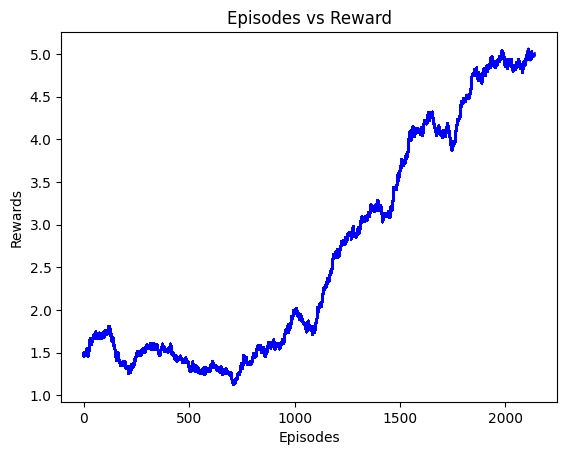

In [6]:
import os


rewards, episodes = [], []
best_eval_reward = 0
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state[0], HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        #next_state, reward, done, info = env.step(action + 1)
        observation, reward, terminated, truncated, info = env.step(action + 1)
        next_state = observation
        done = terminated
        
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            
            ####
            save_graph_dir = './save_graph'
            if not os.path.exists(save_graph_dir):
                os.makedirs(save_graph_dir)
            ####
            pylab.savefig("./save_graph/breakout_onlydqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_onlydqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


In [7]:
best_eval_reward

5.06

# DDQN

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


episode: 0   score: 6.0   memory length: 353   epsilon: 1.0    steps: 353    lr: 0.0001     evaluation reward: 6.0
episode: 1   score: 3.0   memory length: 601   epsilon: 1.0    steps: 248    lr: 0.0001     evaluation reward: 4.5
episode: 2   score: 2.0   memory length: 799   epsilon: 1.0    steps: 198    lr: 0.0001     evaluation reward: 3.6666666666666665
episode: 3   score: 3.0   memory length: 1026   epsilon: 1.0    steps: 227    lr: 0.0001     evaluation reward: 3.5
episode: 4   score: 2.0   memory length: 1223   epsilon: 1.0    steps: 197    lr: 0.0001     evaluation reward: 3.2
episode: 5   score: 0.0   memory length: 1346   epsilon: 1.0    steps: 123    lr: 0.0001     evaluation reward: 2.6666666666666665
episode: 6   score: 2.0   memory length: 1530   epsilon: 1.0    steps: 184    lr: 0.0001     evaluation reward: 2.5714285714285716
episode: 7   score: 1.0   memory length: 1699   epsilon: 1.0    steps: 169    lr: 0.0001     evaluation reward: 2.375
episode: 8   score: 1.0   me

/home/vanshporwal/memory.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.array(sample)
/home/vanshporwal/agent_double.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mini_batch = np.array(mini_batch).transpose()


episode: 553   score: 1.0   memory length: 100056   epsilon: 0.9998871400000025    steps: 172    lr: 0.0001     evaluation reward: 1.47
episode: 554   score: 0.0   memory length: 100178   epsilon: 0.9996455800000077    steps: 122    lr: 0.0001     evaluation reward: 1.47
episode: 555   score: 3.0   memory length: 100407   epsilon: 0.9991921600000175    steps: 229    lr: 0.0001     evaluation reward: 1.49
episode: 556   score: 2.0   memory length: 100605   epsilon: 0.998800120000026    steps: 198    lr: 0.0001     evaluation reward: 1.48
episode: 557   score: 0.0   memory length: 100728   epsilon: 0.9985565800000313    steps: 123    lr: 0.0001     evaluation reward: 1.47
episode: 558   score: 2.0   memory length: 100945   epsilon: 0.9981269200000407    steps: 217    lr: 0.0001     evaluation reward: 1.46
episode: 559   score: 0.0   memory length: 101067   epsilon: 0.9978853600000459    steps: 122    lr: 0.0001     evaluation reward: 1.46
episode: 560   score: 0.0   memory length: 101189

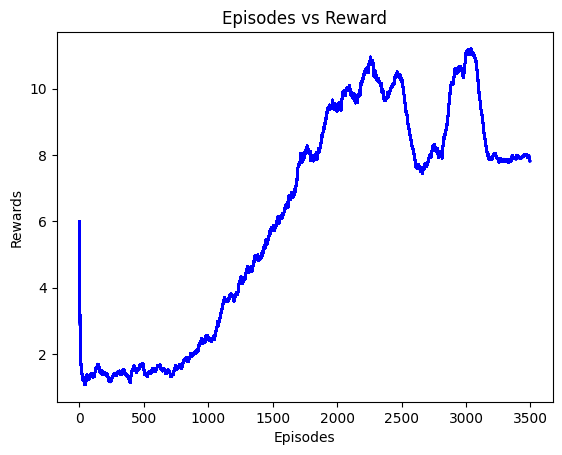

In [10]:
import os


rewards, episodes = [], []
best_eval_reward = 5
for e in range(EPISODES):
    done = False
    score = 0

    history = np.zeros([5, 84, 84], dtype=np.uint8)
    step = 0
    state = env.reset()
    next_state = state
    life = number_lives

    get_init_state(history, state[0], HISTORY_SIZE)

    while not done:
        step += 1
        frame += 1

        # Perform a fire action if ball is no longer on screen to continue onto next life
        if step > 1 and len(np.unique(next_state[:189] == state[:189])) < 2:
            action = 0
        else:
            action = agent.get_action(np.float32(history[:4, :, :]) / 255.)
        state = next_state
        #next_state, reward, done, info = env.step(action + 1)
        observation, reward, terminated, truncated, info = env.step(action + 1)
        next_state = observation
        done = terminated
        
        
        frame_next_state = get_frame(next_state)
        history[4, :, :] = frame_next_state
        terminal_state = check_live(life, info['lives'])

        life = info['lives']
        r = reward

        # Store the transition in memory 
        agent.memory.push(deepcopy(frame_next_state), action, r, terminal_state)
        # Start training after random sample generation
        if(frame >= train_frame):
            agent.train_policy_net(frame)
            # Update the target network only for Double DQN only
            if double_dqn and (frame % update_target_network_frequency)== 0:
                agent.update_target_net()
        score += reward
        history[:4, :, :] = history[1:, :, :]
            
        if done:
            evaluation_reward.append(score)
            rewards.append(np.mean(evaluation_reward))
            episodes.append(e)
            pylab.plot(episodes, rewards, 'b')
            pylab.xlabel('Episodes')
            pylab.ylabel('Rewards') 
            pylab.title('Episodes vs Reward')
            
            ####
            save_graph_dir = './save_graph'
            if not os.path.exists(save_graph_dir):
                os.makedirs(save_graph_dir)
            ####
            pylab.savefig("./save_graph/breakout_dqn.png") # save graph for training visualization
            
            # every episode, plot the play time
            print("episode:", e, "  score:", score, "  memory length:",
                  len(agent.memory), "  epsilon:", agent.epsilon, "   steps:", step,
                  "   lr:", agent.optimizer.param_groups[0]['lr'], "    evaluation reward:", np.mean(evaluation_reward))

            # if the mean of scores of last 100 episode is bigger than 5 save model
            ### Change this save condition to whatever you prefer ###
            if np.mean(evaluation_reward) > 5 and np.mean(evaluation_reward) > best_eval_reward:
                torch.save(agent.policy_net, "./save_model/breakout_dqn.pth")
                best_eval_reward = np.mean(evaluation_reward)


In [11]:
best_eval_reward

11.2